# Lab 7: Twitter data analysis  

In this lab, we will learn how to read JSON files and how to perform exploratory analysis of twitter data. As an extra credit, you will learn how to use API to download tweets on the topic of your choice.

Let us start by importing the needed packages.

In [51]:
import json
import random
import time
import calendar
import codecs
import datetime
import sys
import gzip
import string
import glob
import os
import numpy as np
import dateutil.parser

## Module 0: Reading Tweets

Tweets are saved in the form of a JSON file. Open `onetweet` file in a text editor and study how it looks. This file contains information from a single tweet. The file is written in the JSON format, which is easy for a computer to read and parse. 

**Question 1**. Google `JSON` and try to learn about this particular data format. Explain in one or two paragraphs what you learned.

JSON is a data serialization format which was invented in the early 2000s (arguably 2002) by Douglas Crockford based on the syntax of Javascript.
It is widely used for exchanging structured data between servers & between servers/clients.

It consists of a Java 'map' or Python/Javascript 'dictionary' with character strings for keys. The mapped values can be character strings, numbers (integer or floating point), boolean values (true or false), the value null, a nested JSON 'object' (i.e. a map from character strings to values), or an array of any of those values (including nested arrays or JSON 'objects'). 

Let us read `onetweet` JSON file. We will create an object and print it.

In [52]:
from pprint import pprint
# tweet = json.load(open('onetweet', 'rb').decode('utf8'))
with open('onetweet.json') as f:
    tweet = json.load(f)
pprint(tweet)

{'_id': '264230205529411585',
 'contributors': None,
 'coordinates': {'coordinates': [-73.95639896, 40.71411847], 'type': 'Point'},
 'created_at': '2012-11-02T04:59:24',
 'disaster': '2012_sandy_hurricane_en',
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [{'display_url': 'instagr.am/p/Rg70o6xlkY/',
                        'expanded_url': 'http://instagr.am/p/Rg70o6xlkY/',
                        'indices': [33, 53],
                        'url': 'http://t.co/G0LdsQAz'}],
              'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'geo': {'coordinates': [40.71411847, -73.95639896], 'type': 'Point'},
 'id': '264230205529411585',
 'id_str': '264230205529411585',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': {'attributes': {},
           'bounding_box': {'coordinat

As we can see, each tweet is stored in a dictionary. Although there are more than 20 different keys in the dictionary, we introduce the most important fields which will be used in the rest of this lab.
<ul>
<li>'_id': shows the unique id of this tweet.</li>

<li>'coordinates': shows the location from which the tweet was posted. The field might be null if the tweet contains no location data, or it could contain bounding box information, place information, or GPS coordinates in the form of (longitude, latitude). </li>

<li>'created_at': shows the time the tweet has been created.</li>

<li>'text': shows the text of the tweet.</li>

<li>'user': contains multiple dictionaries describing the user, including the name of this user, the number of followers, the number of friends...</li>
</ul>

**Question 2**. Explain 3 more keys that you find interesting

The 'place' field holds a complex data structure which provides a great deal of detail about the local area where the tweet was posted.

The 'disaster' field identifies whether the tweet is in relation to some major disaster.

The 'possibly_sensitive' field is used, if the tweet contains a link, to identify whether that link points to content that might be 'sensitive'.

In the following code we will load around 4,000 tweets sent from New York City region during Sandy Hurricane from a JSON file `myNYC.json`. As part of this process, we will extract each tweet's post time and create a time series of the number of tweets in each hour during the event.

In [53]:
filePath='smallNYC.json'
localTweetList = []
globalTweetCounter = 0
frequencyMap = {}
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    
    # Try to extract the time of the tweet
    currentTime=dateutil.parser.parse(tweetObj['created_at'])
    currentTime = currentTime.replace(second=0)
    currentTime = currentTime.replace(minute=0)

    # print(currentTime)
    # Increment tweet count
    globalTweetCounter += 1
    
    # If our frequency map already has this time, use it, otherwise add
    if currentTime in frequencyMap.keys():
        timeMap = frequencyMap[currentTime]
        timeMap["count"] += 1
        timeMap["list"].append(tweetObj)
    else:
        frequencyMap[currentTime] = {"count":1, "list":[tweetObj]}

# Fill in any gaps
times = sorted(frequencyMap.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

#timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
timeIntervalStep = datetime.timedelta(hours=1)
while ( thisTime <= lastTime ):
    if ( thisTime not in frequencyMap.keys() ):
        frequencyMap[thisTime] = {"count":0, "list":[]}
        
    thisTime = thisTime + timeIntervalStep

print ("Processed Tweet Count:", globalTweetCounter)

Processed Tweet Count: 4295


## Module 1: Simple Frequency Analysis

In this section, we will cover a few simple analysis techniques for EDA of the available twitter data.

- Twitter Timeline
- Top Twitter Users
- Twitter API
- Posting Frequency Distribution
- Popular Hashtags
- Simple Event Detection
- Language Distributions

### Twitter Timeline 

To build a timeline of Twitter usage, we can simply plot the number of tweets posted per hour.

Time Frame: 2012-10-22 05:00:00 2012-11-02 04:00:00


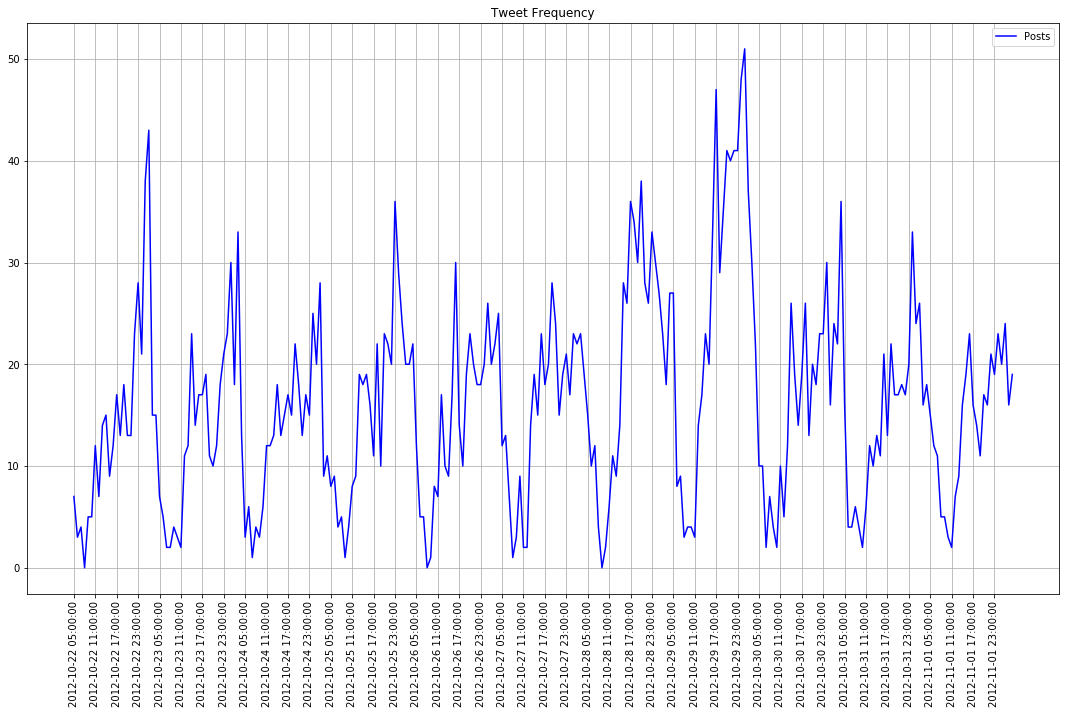

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")

# Sort the times into an array for future use
sortedTimes = sorted(frequencyMap.keys())

# What time span do these tweets cover?
print ("Time Frame:", sortedTimes[0], sortedTimes[-1])

# Get a count of tweets per minute
postFreqList = [frequencyMap[x]["count"] for x in sortedTimes]

# We'll have ticks every thirty minutes (much more clutters the graph)
smallerXTicks = range(0, len(sortedTimes), 6)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
ax.plot(range(len(frequencyMap)), [x if x > 0 else 0 for x in postFreqList], color="blue", label="Posts")
ax.grid(b=True, which=u'major')
ax.legend()

plt.show()

**Question 3**. When is the tweeting activity the largest? Find a wikipedia article about the Sandy Hurricane to understand the timeline of events surrounding it. Discuss if you see a correlation with the tweet frequencies. Select some tweets from different time points and see if the messages are correlated with the events on the ground.

The first spike in tweets occurred on October 22nd as Sandy first formed off the coast of Nicaragua.  <br>
Tweet activity reached its apex close to midnight on October 29th(/30th).<br>
NY Governor Andrew Cuomo declared a state of emergency on October 28th, which matches up with a markedly elevated rate of tweeting on that day.<br>
Twitter activity seems to have spiked the highest throughout October 29th in anticipation of Sandy's landfall in the Mid-Atlantic. It then reached its overall peak later on October 29th as Sandy made landfall in New Jersey.<br>

In [55]:
def getTweets(startTime, endTime, tweetFreqMap):
    sortedTimes=sorted(tweetFreqMap.keys())

    tweetsList=[]

    for currTime in sortedTimes:
        if currTime > endTime:
            break
        elif currTime >= startTime:
            tweetFreqEntry= tweetFreqMap[currTime]
            tweetsList.extend(tweetFreqEntry["list"])
    tweetTexts= [currTweet["text"] for currTweet in tweetsList]
    return tweetTexts



formationStartTime= datetime.datetime(year=2012, month=10, day=22, hour=23, minute=0)
formationEndTime= datetime.datetime(year=2012, month=10, day=23, hour=3, minute=30)

formationTweets= getTweets(formationStartTime, formationEndTime, frequencyMap)
formationTweetCount=len(formationTweets)
formationTweets=formationTweets[0:150]

print("tweets around the time of the storm's formation(count=", formationTweetCount,"):")
print(*formationTweets, sep="\n")
print("\n\n")

dayB4LandfallStartTime= datetime.datetime(year=2012, month=10, day=28, hour=17, minute=0)
dayB4LandfallEndTime= datetime.datetime(year=2012, month=10, day=28, hour=23, minute=0)

dayB4LandfallTweets= getTweets(dayB4LandfallStartTime, dayB4LandfallEndTime, frequencyMap)
dayB4LandfallTweetCount=len(dayB4LandfallTweets)
dayB4LandfallTweets=dayB4LandfallTweets[0:150]

print("tweets the day before the storm's landfall(count=", dayB4LandfallTweetCount,"):")
print(*dayB4LandfallTweets, sep="\n")
print("\n\n")


landfallStartTime= datetime.datetime(year=2012, month=10, day=29, hour=16, minute=45)
landfallEndTime= datetime.datetime(year=2012, month=10, day=30, hour=2, minute=0)

landfallTweets= getTweets(landfallStartTime, landfallEndTime, frequencyMap)
landfallTweetCount=len(landfallTweets)
landfallTweets=landfallTweets[0:350]

print("tweets during the storm's landfall(count=", landfallTweetCount,"):")
print(*landfallTweets, sep="\n")
print("\n\n")


tweets around the time of the storm's formation(count= 145 ):
I want a rose gold MK watch.. Candice has hers on &amp;&amp; I'm jealous lol.
#IgniteNYC (@ Sheraton New York Hotel &amp; Towers w/ 41 others) http://t.co/H7tGUgUn
You tend to appreciate the ladies dressed down after work in her sweats walking the dog around the way.
I'm at Libretto's Pizzeria (New York, NY) http://t.co/CmgSq7Jb
I would like to leave my room, but i hear visitors and i don't feel like saying hi to all of them.
http://t.co/5MeoNgIP
@xobeautyKills_ call me !
I'm at Atrium NYC (New York, NY) http://t.co/ahkftTqP
@JamieSarro saw her today with the little puppies ;) while I was walking down to Lincoln!
🙌🙌🙌 you got this babe 😘“@DjFrassVybzNYC: Bouta nail this interview”
@AlecMapa Kills me ... Every.  Time.
I'll be damned if I feed a chick. It ain't like me to split a piece of dry pita.
Doucky no puede ver un sueter en el mueble http://t.co/IyY6gY2l
Wow. Chris Matthews just schooled  kid.
#dunkguy
@Hkleeeee ......Ka

Tweets during the spike on October 22nd seem to have been caused by a 2012 presidential debate rather than the news of Sandy's formation.<br>
A few tweets during the elevated activity on October 28th do reference the coming storm and cancellations that result from it.<br>
Most tweets during the activity spike during landfall on October 29th are just complaining about how bored they are being stuck inside, while some later in that spike reference the flooding and power outages.

### Top Twitter Users

The following piece of code reveals the users that produced the most tweets. 

In [56]:
# Create maps for holding counts and tweets for each user
globalUserCounter = {}
globalUserMap = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        
        if user not in globalUserCounter:
            globalUserCounter[user] = 1
            globalUserMap[user] = [tweet]
        else:
            globalUserCounter[user] += 1
            globalUserMap[user].append(tweet)

print ("Unique Users:", len(globalUserCounter.keys()))

Unique Users: 3042


In [60]:
usersSortedByTweetCount = sorted(globalUserCounter, key=globalUserCounter.get, reverse=True)
print ("Top Ten Most Prolific Users:")
for u in usersSortedByTweetCount[:10]:
    print (u, globalUserCounter[u], "\n\t", "Random Tweet:", globalUserMap[u][0]["text"], "\n----------")

Top Ten Most Prolific Users:
Young_Boss718 37 
	 Random Tweet: That random text  I had got be for LMFAO shit was funny 
----------
frankieciv608 15 
	 Random Tweet: “@JohnKincade Dear Donald Trump,
Americans &amp; Republicans chose to not involve you in this election between Prez &amp; Romney.
Please go away.” 
----------
Cocky_Johnny 15 
	 Random Tweet: @_tinaDeex3 LMAO #Dead 
----------
labroides 14 
	 Random Tweet: @SharkDevocean best of luck. That's awesome 
----------
ReelTalker 12 
	 Random Tweet: @FilmFatale_NYC also, in other news, i totally thought it was idris who tweeted me. Saw the pic and got  excited :-) 
----------
Amooniac 11 
	 Random Tweet: Je Hyper nul en Francais mais je sais qu'on ne dit pas le PLUS piire ! SEIGNEUR aidez moi a comprendre ce qui n'a pas marché ak @mhathe911 
----------
kcastrox3 11 
	 Random Tweet: Cuz this love is a sure thing. 
----------
carolsommers727 11 
	 Random Tweet: @coreymach lookin spiffy 👌 
----------
_LizmaryA 11 
	 Random Tweet: Hey 

**Question 4**. Find and print the top 10 users with the most friends. Find and print the top 10 users with the most followers. 

In [61]:
userFollowerCounts = {}
userFriendCounts = {}

for periodTweets in frequencyMap.values():
    for currTweet in periodTweets["list"]:
        currUser = currTweet["user"]
        currUserName= currUser["screen_name"]

        if currUserName not in userFollowerCounts:
            userFollowerCounts[currUserName] = currUser["followers_count"]
            userFriendCounts[currUserName] = currUser["friends_count"]

usersSortedByFriendCounts= sorted(userFriendCounts, key=userFriendCounts.get, reverse=True)
print("Ten Users with most Friends:")
for currUser in usersSortedByFriendCounts[:10]:
    print(currUser)
print("\n")

usersSortedByFollowerCounts= sorted(userFollowerCounts, key=userFollowerCounts.get, reverse=True)
print("Ten Users with most Followers:")
for currUser in usersSortedByFollowerCounts[:10]:
    print(currUser)





Ten Users with most Friends:
mstupenengo
GinsburgJobs
WeAreJocelyn
MrThugZilla2K15
davesurber
55_althani
EddieJMontanez
andrewcotto
MargaretMolloy
tupaclivesss


Ten Users with most Followers:
mstupenengo
iJokes_
felixsalmon
EmersonOverton
umakhouny
AgramyQ8
55_althani
QueensMuseum
JosephWakile
Majovargas_


### Distribution of Postings

It appears a few users were posting to Twitter a lot. But how often did most Twitter users tweet during this time? We can build a histogram to see this distribution.


<ipython-input-62-5cf4e4cc4dad>:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(


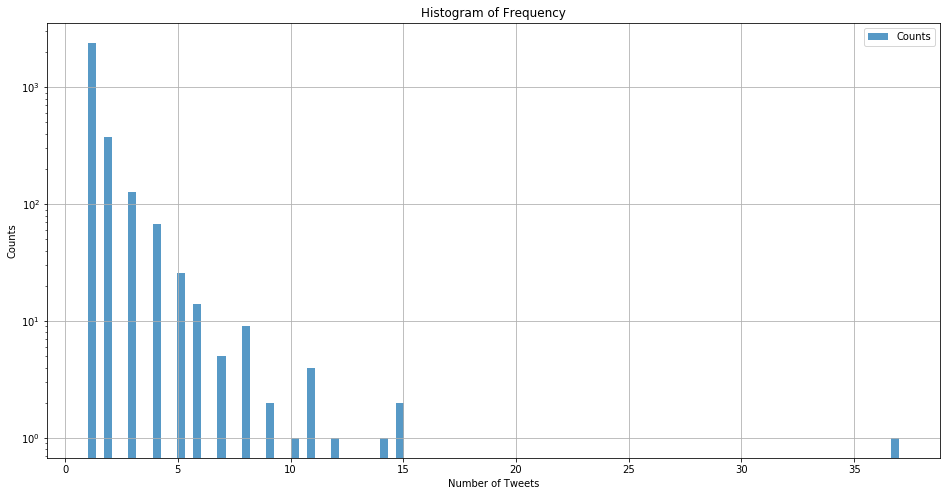

In [62]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.hist(
    [globalUserCounter[x] for x in globalUserCounter], 
    bins=100, 
    normed=0, 
    alpha=0.75,
    label="Counts",
    log=True)

plt.xlabel('Number of Tweets')
plt.ylabel('Counts')
plt.title("Histogram of Frequency")
plt.grid(True)
plt.legend()

plt.show()

**Question 5**. Study 3 users with the most posts. What were they tweeting about?

In [66]:
for currUser in usersSortedByTweetCount[:3]:
    print("prolific user ", currUser, ":", sep="")
    userTweets= globalUserMap[currUser][:50]
    userTweetsText = [currTweet["text"] for currTweet in userTweets]
    print(*userTweetsText, sep="\n")
    print("\n")

prolific user Young_Boss718:
That random text  I had got be for LMFAO shit was funny
@MeerGotGame don't try and find shit lol
U inbox her on fb or text her
That wax museum is a fool in New York shit be real af
I kinda just felt when she just said idgaf lol
We be on the loud shit
Y'all be smoking that low volume
@BossBitchShxt chill out Monae you know I fucks with fab lol
I got my list tho 🙈🙉🙊
@The_Good_Fella9 it's ok
@NOFcks_Givn gave that head to ?
PART2
@The_Good_Fella9 word she's cool af
i wonder who had crush on me on twitter 😜😝😛😵
White girls don't have butts LMFAO
@BricksFromPluto lol
@SugarCocaine_ well I heard mad down south ppl say it that's why I ask
Getting alil sleepy
Moms gone for the whole night shit just about to smoke &amp; kick it with da homies
@LiyahhDoeee I know that's not you in them heels and skirt
@MikeyGotBudd I fucks with the mishka shirt fam
@Loud_Everyday 💯 already know
@She_Suckedd nigga shut up 😒
The pic jaida just posted -_-
No more talking, let’s be about 

Young_Boss718 was tweeting about various things, with some focus on women/sex.<br>
frankieciv608 was very interested in politics (I'd forgotten Trump was that involved in national politics even back in 2012).<br>
Cocky_Johny was more explicitly obsessed with women (in relation to sex) & sex itself.

### Average Number of Posts

In [67]:
avgPostCount = np.mean([globalUserCounter[x] for x in globalUserCounter])
print("Average Number of Posts:", avgPostCount)

Average Number of Posts: 1.4119000657462195


### Popular Hashtags

Hashtags give us a quick way to view the conversation and see what people are discussing. Getting the most popular hashtags is just as easy as getting the most prolific users.


In [68]:
# A map for hashtag counts
hashtagCounter = {}

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            
            if ( hashtagString not in hashtagCounter ):
                hashtagCounter[hashtagString] = 1
            else:
                hashtagCounter[hashtagString] += 1

print ("Unique Hashtags:", len(hashtagCounter.keys()))
sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
print ("Top Twenty Hashtags:")
for ht in sortedHashtags[:20]:
    print ("\t", "#" + ht, hashtagCounter[ht])

Unique Hashtags: 997
Top Twenty Hashtags:
	 #sandy 108
	 #nyc 47
	 #hurricanesandy 26
	 #newyork 12
	 #brooklyn 9
	 #halloween 8
	 #instagood 8
	 #photooftheday 8
	 #frankenstorm 8
	 #hurricane 8
	 #centralpark 7
	 #debates 6
	 #instamood 6
	 #satstudytime 6
	 #igers 5
	 #picoftheday 5
	 #instagramhub 5
	 #instadaily 5
	 #oomf 5
	 #newyorkcity 5


### Event Detection w/ Keyword Frequency

Twitter is good for breaking news. When an impactful event occurs, we often see a spike on Twitter of the usage of a related keyword. Some examples are below.


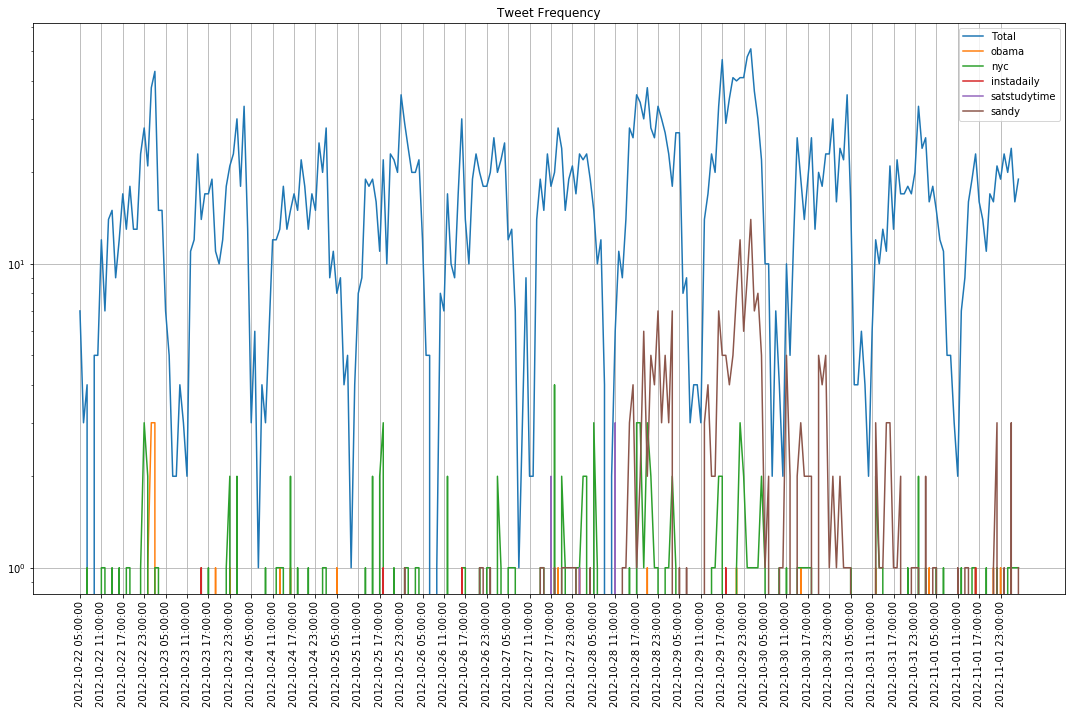

In [72]:
# What keywords are we interested in?
targetKeywords = ["obama", "nyc"]
targetKeywords.append("instadaily")
targetKeywords.append("satstudytime")
targetKeywords.append("sandy")

# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if keyword in tweetString:
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

ax.plot(range(len(frequencyMap)), totalCount, label="Total")


for keyword in targetKeywords:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.yscale("log")
plt.show()

**Question 6**. Study some example codes with 2 different hashtags. Explain how are those messages different. 

The other, non-Sandy-related hashtags only showed up occasionally, and never in large numbers.

**Question 7**. Which among the top 20 hashtags are related to Sandy. What are the most popular non-Sandy hashtags? 

The following top hashtags are (at least probably somewhat) related to Sandy: <br>
sandy, nyc, hurricanesandy, newyork, brooklyn, frankenstorm, hurricane, centralpark, and newyorkcity


The remaining top hashtags are unrelated to Sandy:<br>
halloween, instagood, photooftheday, debates, instamood, satstudytime, igers, picoftheday, instagramhub, instadaily, and oomf

### Language Distribution

The following code gives an insight into the languages used for the tweets in your data.


In [ ]:
# A map for counting each language
languageCounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        lang = tweet["lang"]
        
        if lang not in languageCounter:
            languageCounter[lang] = 1
        else:
            languageCounter[lang] += 1
            
languages = sorted(languageCounter.keys(), key=languageCounter.get, reverse=True)

for l in languages:
    print(l, languageCounter[l])

In [ ]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.bar(
    np.arange(len(languages)),
    [languageCounter[x] for x in languages],
    log=True)

plt.xticks(np.arange(len(languages)) + 0.5, languages)
plt.xlabel('Languages')
plt.ylabel('Counts (Log)')
plt.title("Language Frequency")
plt.grid(True)

plt.show()

**Quesiton 8**. Now that you have experience in extracting different types of information from twitter data, perform your own EDA. Produce a 1-page report providing some interesting insights about the Sandy twitter data.

## Module 2: Classification

In this part of the lab, we will work on a binary classificaiton problem. In particular, we would like to see how easy it is to discriminate between tweets with hashtag #sandy and the rest of them. To do it, we will first create labels: positive tweets will be those with hashtag #sandy and negative those without the hashtag. Then, we will create a bag-of-words vector out of each tweet, but we will exclude word "#sandy". To produce the bag-of-words representation we will use the `CountVectorizer` functionality 

In [ ]:
import pandas as pd
import numpy as np
import codecs, json

"""
Step 1. Create sentences and labels from json file. 
"""
filePath='smallNYC.json'
sents = []
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    sents.append(tweetObj['text'])
    
"""
Step 2.1. Get label. If sent contains '#sandy', label=1; otherwise, label=0
"""
labels = np.array(['#sandy' in sent.split() for sent in sents], dtype='int')
print(pd.Series(labels).value_counts())
"""
Step 2.2. Represent the data into Bag-of-words features, i.e, each sentence is a 
            vector of word counts. 
          a). Only select words with frequency >= 5
          b). Remove label words '#sandy'
"""

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words = ['#sandy'])
features = vectorizer.fit_transform(sents)


print('#sandy' in vectorizer.get_feature_names())
print(features.toarray())
print(vectorizer.get_feature_names())

**Quesiton 9**. Given the data set of labeled tweets, you have to train a classification model and check the accuracy. Remember to first split the data into training and test. You should explore kNN classification, decision tree classification, Random Forest classification.

**Question 10**. Train the so-called *Logistic regression classifier* and check its accuracy. Compare with the results from *Question 9*. The following lines of code will be useful to do it.

In [ ]:
"""
Step 3. Divide data into train and test 
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42) 
import time
from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression(solver='lbfgs')
start_time = time.time()
clf.fit(X_train, y_train)
print('Time for %s fitting: %.3f' % ('LogisticRegression', time.time() - start_time))
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('Test Perf ACC: %.3f, AUC: %.3f' %(accuracy, auc))